# Identify Fraudulent Credit Card Users

### It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### The techniques applied here on one such dataset can help classify such fraudulent transactions 


# Importing libraries

In [187]:
import os
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('ggplot')

# Importing Credit Card dataset

In [188]:
current_dir = os.getcwd()
path_to_csv = os.path.abspath(os.path.join(current_dir, 'creditcard.csv'))
data = pd.read_csv(path_to_csv)


In [189]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Quality Check

## Check for null/missing values

In [190]:
# percentage of missing values in each column
round(100 * (data.isnull().sum()/len(data)),2).sort_values(ascending=False)

Class     0.0
V14       0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V15       0.0
Amount    0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Time      0.0
dtype: float64

In [191]:
# percentage of missing values in each row
round(100 * (data.isnull().sum(axis=1)/len(data)),2).sort_values(ascending=False)

284806    0.0
94937     0.0
94931     0.0
94932     0.0
94933     0.0
         ... 
189864    0.0
189863    0.0
189862    0.0
189861    0.0
0         0.0
Length: 284807, dtype: float64

## Note: No missing/null values in the given dataset

## Duplicate check

In [192]:
print(f"Size of dataframe before dropping duplicate rows - {data.shape[0]}")
data.drop_duplicates(subset=None, inplace=True) 
print(f"Size of dataframe after dropping duplicate rows - {data.shape[0]}")

Size of dataframe before dropping duplicate rows - 284807
Size of dataframe after dropping duplicate rows - 283726


# Exploratory Data Analysis

In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     28

## Note: Different types of variables in this dataset are - float64, Int64

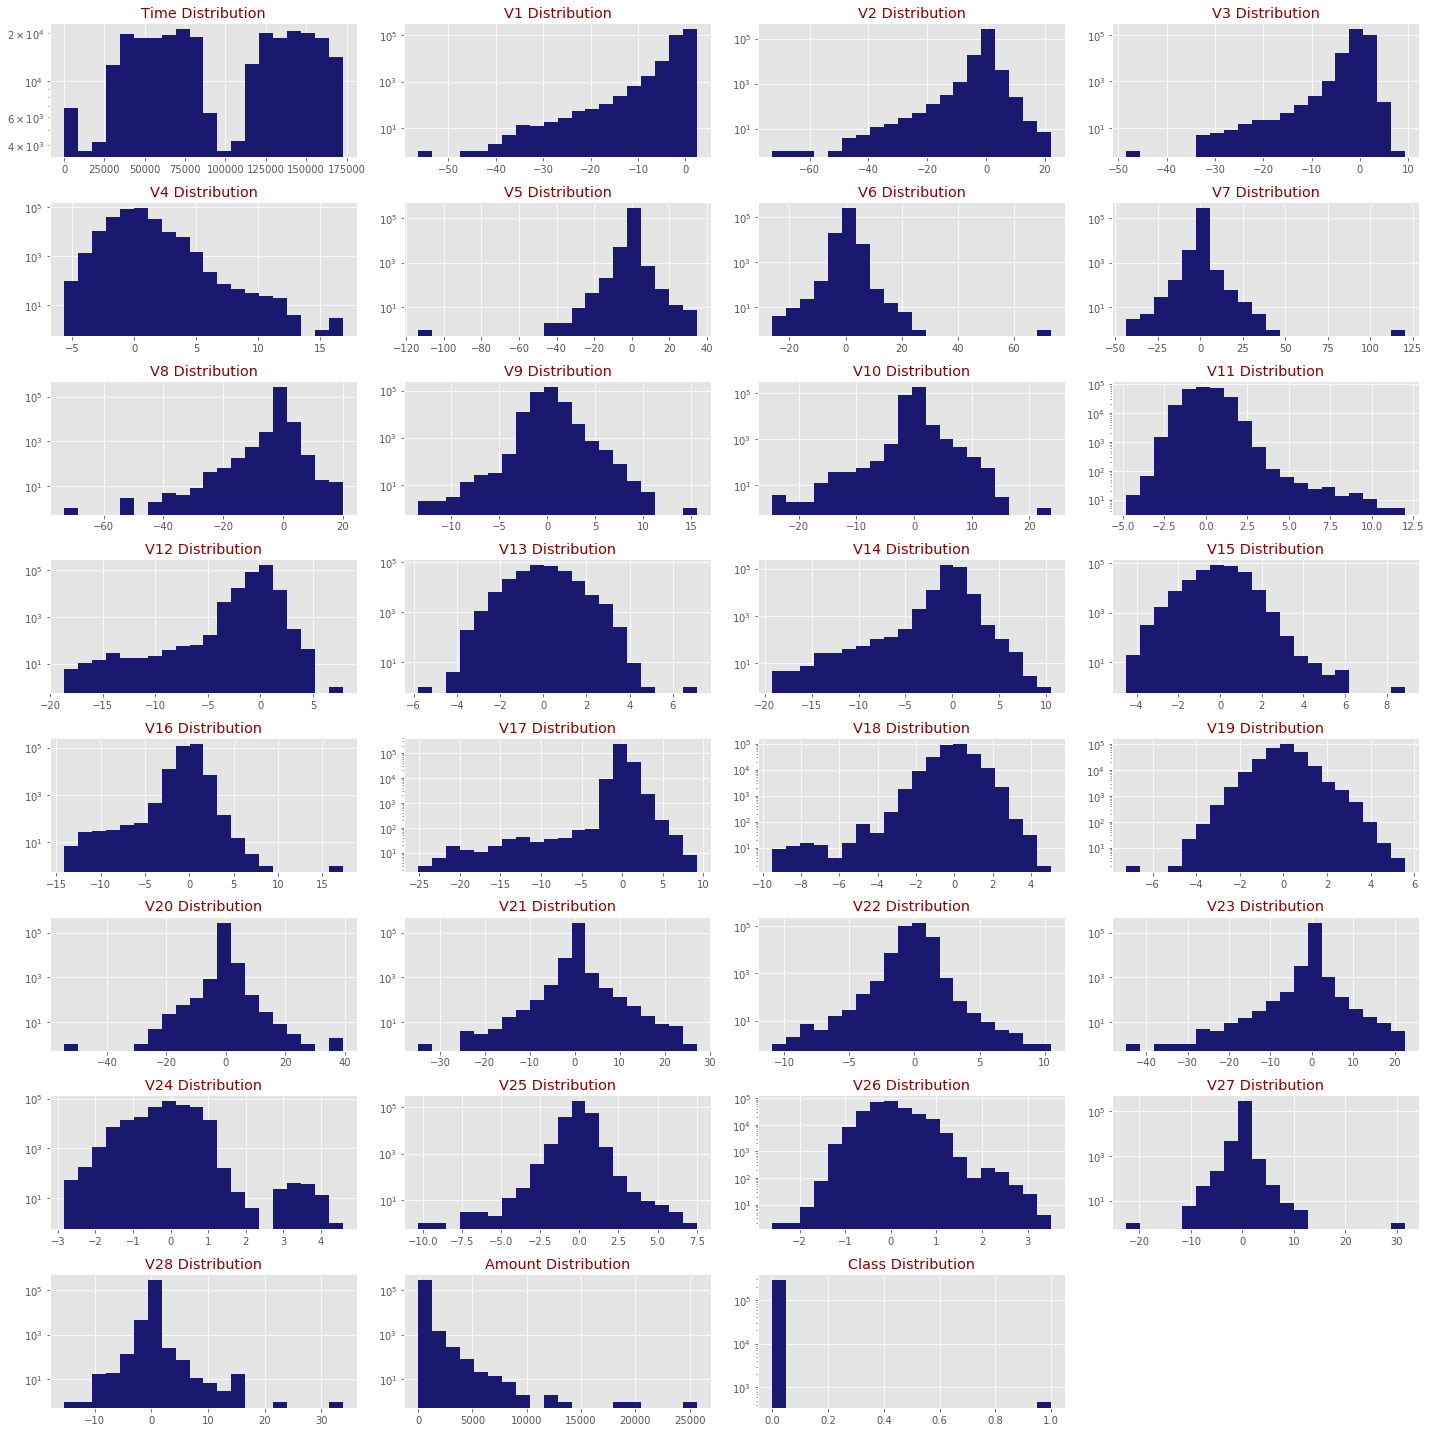

In [194]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()
draw_histograms(data,data.columns,8,4)

In [195]:
#fraud vs. normal transactions 
counts = data.Class.value_counts()
normal = counts[0]
fraudulent = counts[1]
perc_normal = (normal/(normal+fraudulent))*100
perc_fraudulent = (fraudulent/(normal+fraudulent))*100

Text(0.5, 0, 'Class (0:Non-Fraudulent, 1:Fraudulent)')

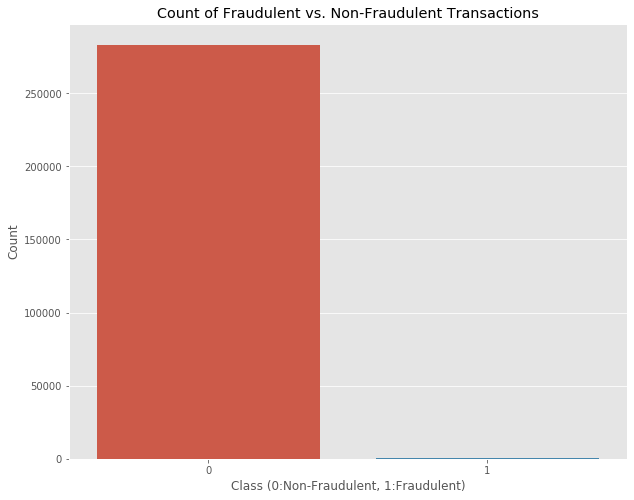

In [196]:
plt.figure(figsize=(10,8))
sns.barplot(x=counts.index, y=counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Fraudulent, 1:Fraudulent)')

### Note: There are 283253 non-fraudulent transactions (99.833%) and 473 fraudulent transactions (0.167%)

### Training our model on the original dataset for creating a predictive model would lead to a lot of errors due to overfitting, misclassifying the fraudulent transactions as legitimate activity due to skewed data.

## Correlation Matrix

Text(0.5, 1, 'Heatmap of Correlation')

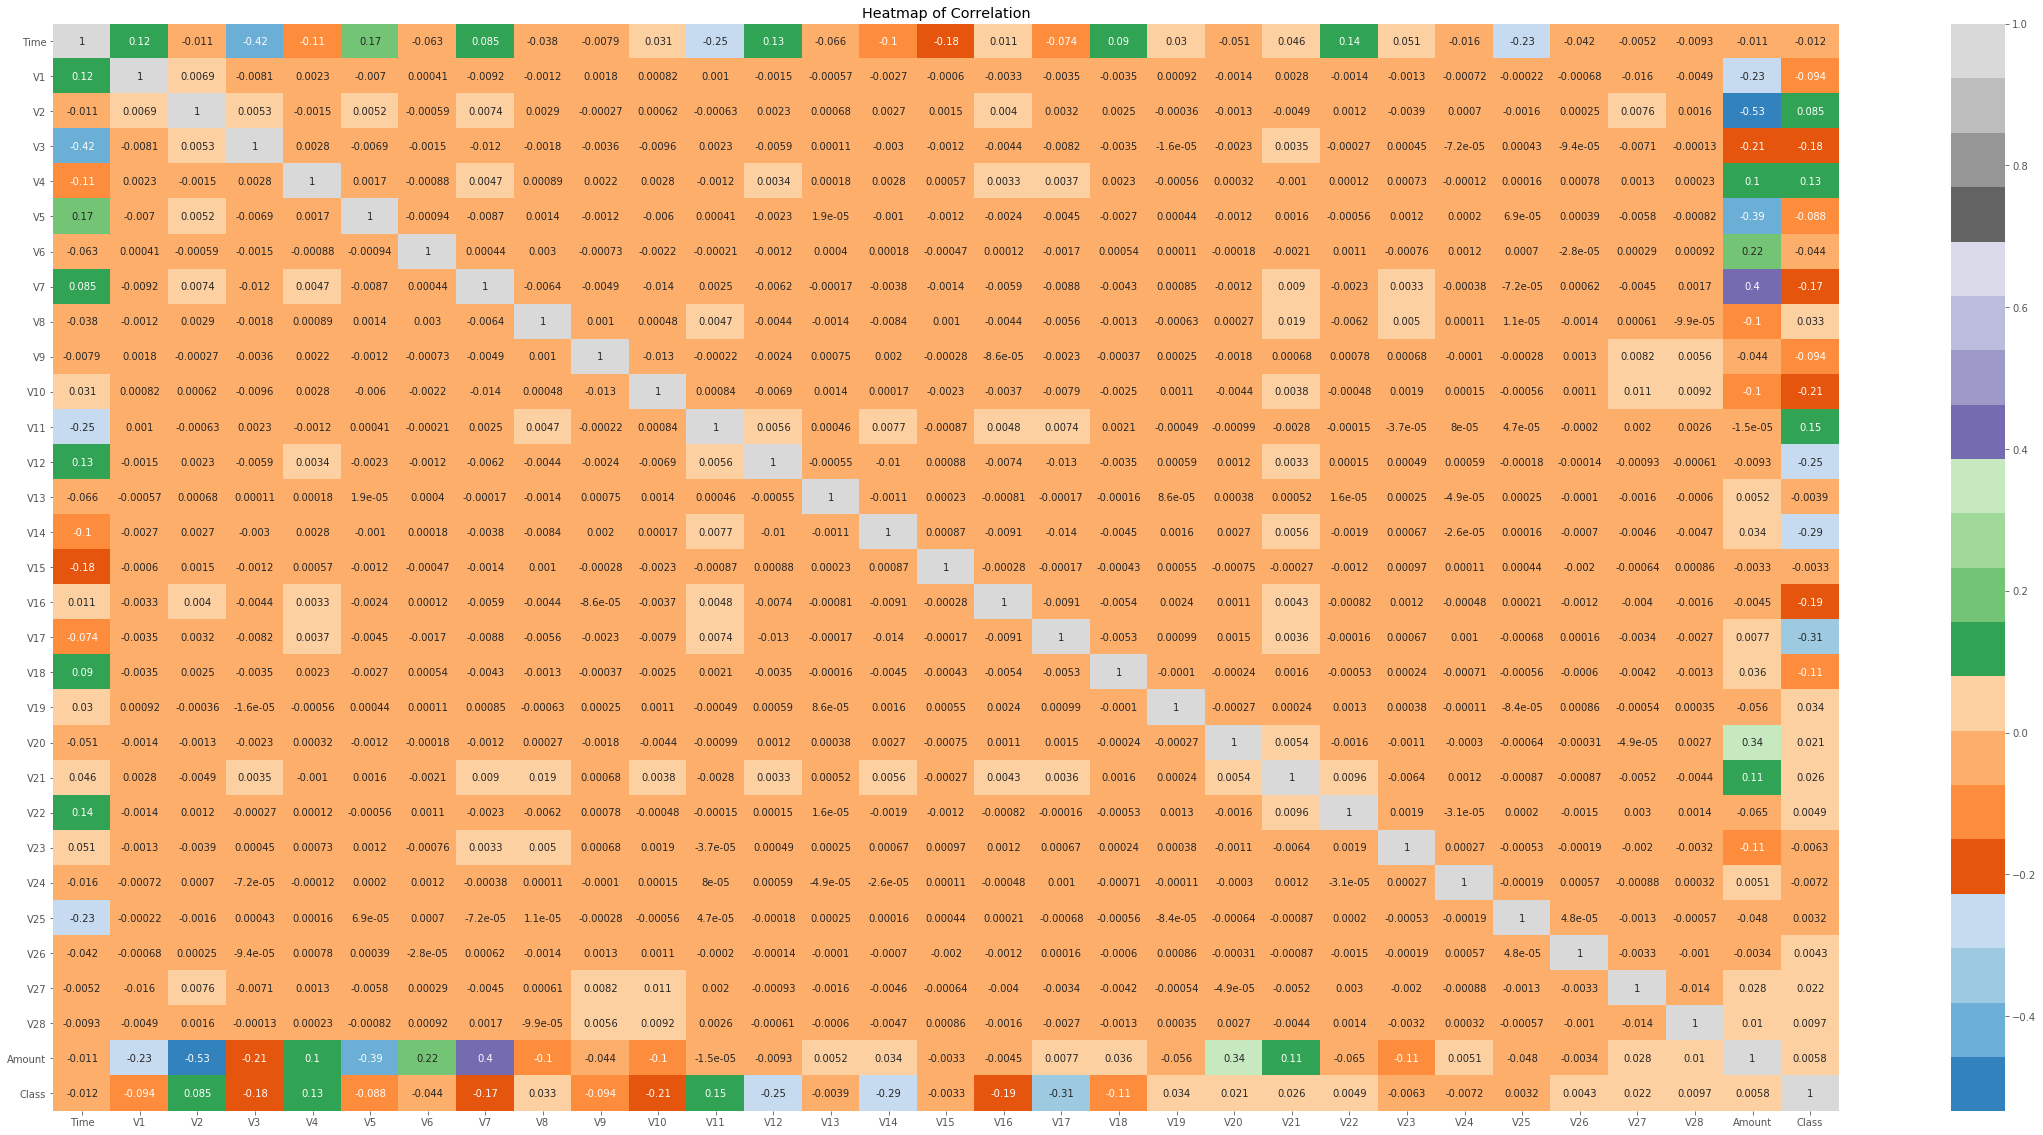

In [197]:
#heatmap
corr = data.corr()
plt.figure(figsize=(40,20))
heat = sns.heatmap(data=corr, annot=True, cmap="tab20c")
plt.title('Heatmap of Correlation')

### Note: The heatmap clearly shows which all variable are multicollinear in nature, and which variable have high collinearity with the target variable.

### The amount and time attributes are not scaled with the rest of the features in the dataset. These can be scaled using standard scaler

In [198]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)
amount = data['scaled_amount']
time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'amount', amount)
data.insert(1, 'time', time)

In [199]:
data.head()

,amount,time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.774718,-0.995290,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.268530,-0.995290,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.959811,-0.995279,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.411487,-0.995279,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.667362,-0.995267,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Sampling and redistributing dataset to avoid the class imbalance problem

## Here we are undersampling the majority class to remove the imbalance between targte classes before doing the model building exercise

In [200]:
data = data.sample(frac=1)

fraud_data = data.loc[data['Class']==1]
nfraud_data = data.loc[data['Class']==0][:fraudulent]

normal_distributed_df = pd.concat([fraud_data, nfraud_data])

# Shuffle dataframe rows
ndata = normal_distributed_df.sample(frac=1, random_state=42)

ndata

,amount,time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
254344,2.296065,0.846042,-0.129778,0.141547,-0.894702,-0.457662,0.810608,-0.504723,1.373588,-0.209476,...,0.399447,-0.032643,-0.246526,0.484108,0.359637,-0.435972,-0.248480,0.021527,0.109192,1
198868,-0.292032,0.564034,0.432554,1.861373,-4.310353,2.448080,4.574094,-2.979912,-2.792379,-2.719867,...,0.318853,-1.384477,-0.348904,-3.979948,-0.828156,-2.419446,-0.767070,0.387039,0.319402,1
42279,3.747462,-0.513161,-7.584234,-5.506332,0.564691,0.117887,-0.616870,-0.047480,-0.538770,0.484054,...,-4.042486,-1.236374,1.463392,2.824016,0.220389,1.454652,0.012141,0.859123,-1.238281,0
30100,0.536782,-0.574916,-3.218952,2.708535,-3.263042,1.361866,-1.645776,-1.852982,-3.069958,-1.796876,...,0.571654,1.807877,-0.890421,-0.325814,0.123040,-0.093014,0.232106,-0.310519,-0.745295,1
141257,-0.305938,-0.005741,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,...,1.129532,1.066550,-0.521657,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88876,-0.292032,-0.262800,1.140865,1.221317,-1.452955,2.067575,0.854742,-0.981223,0.325714,-0.037721,...,-0.067712,-0.377597,-0.793460,-0.132333,-0.331586,0.664878,-0.309312,0.099942,0.122988,1
163586,0.597970,0.368707,0.949241,1.333519,-4.855402,1.835006,-1.053245,-2.562826,-2.286986,0.260906,...,0.424608,0.306598,-0.854627,0.101177,-0.281497,0.024444,-0.107944,0.625289,0.315677,1
89018,1.333194,-0.262107,-0.767348,-0.509258,1.994938,-0.800151,-0.348994,0.132989,0.480147,-0.307415,...,0.185256,0.069203,0.588155,-0.385630,0.266012,0.279365,-0.071677,-0.285076,-0.452130,0
150715,-0.147406,0.108969,-11.397727,7.763953,-18.572307,6.711855,-10.174216,-4.395918,-15.893788,2.083013,...,0.208879,0.339007,1.342923,0.239217,0.534644,-0.174965,-0.500240,-1.722060,-0.574339,1


# Train and test data split before model selection and fitting

In [201]:
X= ndata.iloc[:, ndata.columns != 'Class']
y = ndata.iloc[:, ndata.columns == 'Class']

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [202]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Using Decision Tree Classifier

In [203]:
classifier = DecisionTreeClassifier(criterion = 'gini', random_state= 0 )
classifier.fit(X_train, y_train.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

amount, Score: 0.014295
time, Score: 0.0
V1, Score: 0.0
V2, Score: 0.003762
V3, Score: 0.003762
V4, Score: 0.04765
V5, Score: 0.0
V6, Score: 0.008464
V7, Score: 0.017679
V8, Score: 0.0
V9, Score: 0.0
V10, Score: 0.0
V11, Score: 0.021825
V12, Score: 0.0
V13, Score: 0.024589
V14, Score: 0.754383
V15, Score: 0.021645
V16, Score: 0.005477
V17, Score: 0.0
V18, Score: 0.0
V19, Score: 0.013322
V20, Score: 0.016012
V21, Score: 0.009549
V22, Score: 0.004837
V23, Score: 0.001819
V24, Score: 0.0
V25, Score: 0.018642
V26, Score: 0.0
V27, Score: 0.0
V28, Score: 0.012288


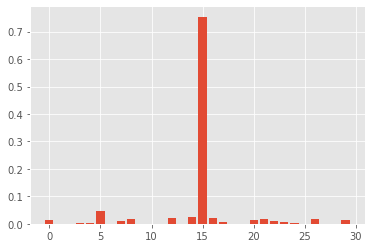

Top 10 features according to Decision tree classifier


[('V14', 0.754383),
 ('V4', 0.04765),
 ('V13', 0.024589),
 ('V11', 0.021825),
 ('V15', 0.021645),
 ('V25', 0.018642),
 ('V7', 0.017679),
 ('V20', 0.016012),
 ('amount', 0.014295),
 ('V19', 0.013322)]

In [204]:
# get importance
importance = classifier.feature_importances_

# summarize feature importance

features = list(X.columns)
feature_importance = {}
for i,v in enumerate(importance):
    print(f'{features[i]}, Score: {round(v, 6)}')
    feature_importance[features[i]] = round(v, 6)


# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

sorted_tuples = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
print(f"Top 10 features according to Decision tree classifier") 
sorted_tuples[:10]

In [205]:
y_pre = classifier.predict(X_test)

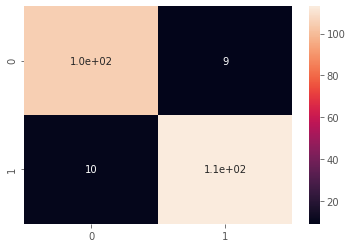

In [206]:
cm_grid = confusion_matrix(y_test,y_pre)
sns.heatmap(cm_grid, annot=True)

In [207]:
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       114
           1       0.93      0.92      0.92       123

    accuracy                           0.92       237
   macro avg       0.92      0.92      0.92       237
weighted avg       0.92      0.92      0.92       237



In [208]:
classifier.score(X_test,y_test)

0.919831223628692

# Using Naive Bayes Classifier

In [209]:
classifier = GaussianNB()
classifier.fit(X_train, y_train.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [210]:
y_pre = classifier.predict(X_test)

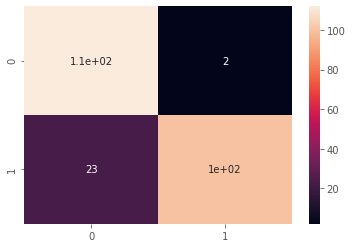

In [211]:
cm_grid = confusion_matrix(y_test,y_pre)
sns.heatmap(cm_grid, annot=True)

In [212]:
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       114
           1       0.98      0.81      0.89       123

    accuracy                           0.89       237
   macro avg       0.91      0.90      0.89       237
weighted avg       0.91      0.89      0.89       237



In [213]:
classifier.score(X_test,y_test)

0.8945147679324894

# Using Logistic Regression

In [214]:
classifier = LogisticRegression(solver='liblinear', random_state=0)
classifier.fit(X_train, y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

amount, Score: 0.335512
time, Score: -0.339039
V1, Score: 0.26976
V2, Score: 0.097703
V3, Score: 0.014156
V4, Score: 0.749339
V5, Score: 0.278857
V6, Score: -0.372224
V7, Score: -0.251167
V8, Score: -0.315133
V9, Score: -0.172798
V10, Score: -0.206947
V11, Score: 0.45631
V12, Score: -0.601862
V13, Score: -0.481196
V14, Score: -1.049485
V15, Score: 0.128181
V16, Score: -0.399524
V17, Score: -0.390372
V18, Score: 0.009747
V19, Score: -0.136258
V20, Score: -0.532169
V21, Score: 0.13507
V22, Score: 0.615287
V23, Score: 0.18041
V24, Score: -0.163372
V25, Score: -0.306339
V26, Score: -0.257801
V27, Score: 0.429985
V28, Score: 0.673277


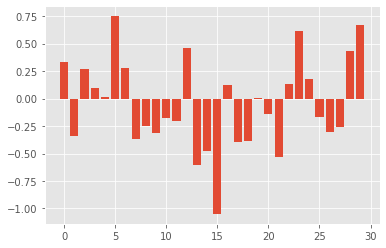

No clear pattern of important and unimportant features can be recognized here from the feature importance scores


In [215]:
# get importance
importance = classifier.coef_[0]
# summarize feature importance

features = list(X.columns)
feature_importance = {}
for i,v in enumerate(importance):
    print(f'{features[i]}, Score: {round(v, 6)}')
    feature_importance[features[i]] = round(v, 6)


# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

print(f"No clear pattern of important and unimportant features can be recognized here from the feature importance scores")

In [216]:
y_pre = classifier.predict(X_test)

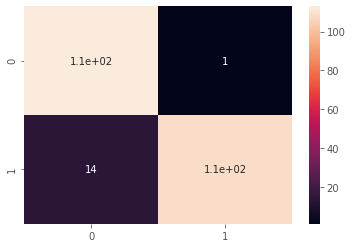

In [217]:
cm_grid = confusion_matrix(y_test,y_pre)
sns.heatmap(cm_grid, annot=True)

In [218]:
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       114
           1       0.99      0.89      0.94       123

    accuracy                           0.94       237
   macro avg       0.94      0.94      0.94       237
weighted avg       0.94      0.94      0.94       237



In [219]:
classifier.score(X_test,y_test)

0.9367088607594937